# Классификация и кластеризация с помощью нейронных сетей

В данной лабораторной работе рассмотрим следующие нейронные сети:

*   Самоорганизующаяся карта Кохонена
*   Вероятностная нейронная сеть
*   Прямое распространение сигнала и обратное распространение ошибки

**Виды ирисов, которые будут рассмотрены:**


> 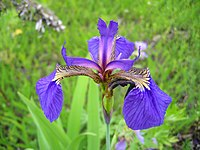 Iris Setosa


> 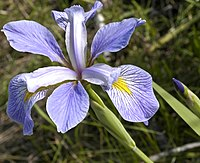 Iris Verginica

> 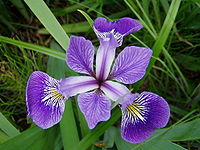 Iris Versicolor

# Начальная обработка данных



In [394]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# OneHotEncoder – этот кодировщик берёт столбец с категориальными данными, 
# который был предварительно закодирован в признак, и создаёт для него несколько новых столбцов. 
# Числа заменяются на единицы и нули, в зависимости от того, какому столбцу какое значение присуще.
enc = OneHotEncoder()
Y = enc.fit_transform(y[:, np.newaxis]).toarray()

# Масштабируйте данные, чтобы иметь среднее значение 0 и дисперсию 1,
# что важно для сходимости нейронной сети.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.4, random_state=1)

n_features = X.shape[1]
print(n_features, "– кол-во признаков")
n_classes = Y.shape[1]
print(n_classes, "– кол-во классов (setosa, versicolor, virginica)")

4 – кол-во признаков
3 – кол-во классов (setosa, versicolor, virginica)




> **Визуализация исходных данных**



In [395]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


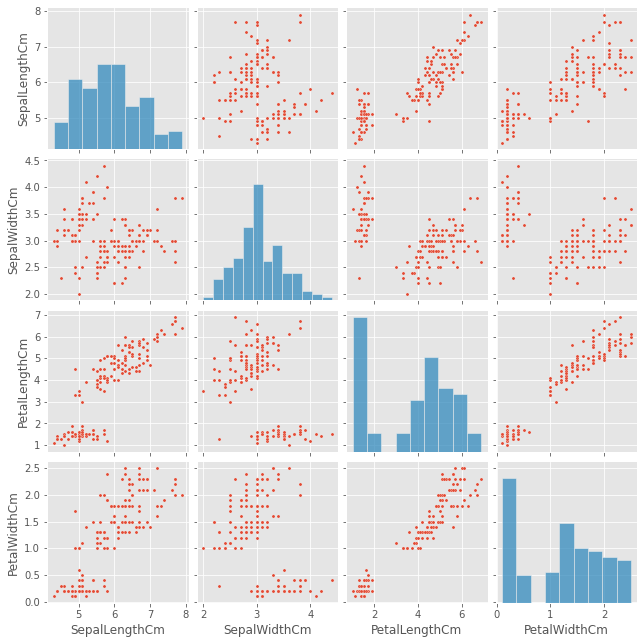

               count      mean       std  min  25%   50%  75%  max
SepalLengthCm  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9
SepalWidthCm   150.0  3.054000  0.433594  2.0  2.8  3.00  3.3  4.4
PetalLengthCm  150.0  3.758667  1.764420  1.0  1.6  4.35  5.1  6.9
PetalWidthCm   150.0  1.198667  0.763161  0.1  0.3  1.30  1.8  2.5


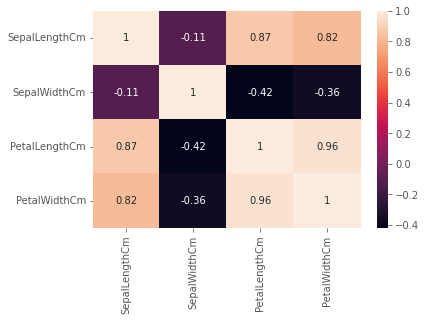

In [396]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

iris_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PRACTICE/IRIS_FISHER/Iris.csv')
data_iris = iris_dataset[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']]
g = sns.pairplot(data_iris, plot_kws={"s": 10})
g.fig.set_size_inches(9, 9)
plt.show()

print(data_iris.describe().T)
sns.heatmap(data_iris.corr(), annot=True)

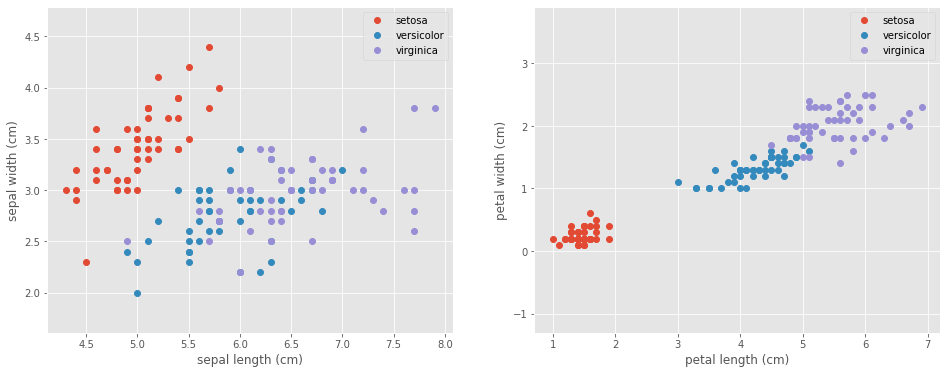

In [397]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

Признаки:
*   Petal length (длина лепестка)
*   Petal width (ширина лепестка)
*   Sepal length (длина чашелистика)
*   Sepal width (ширина чашелистика)


> **Определение наиболее важных признаков**




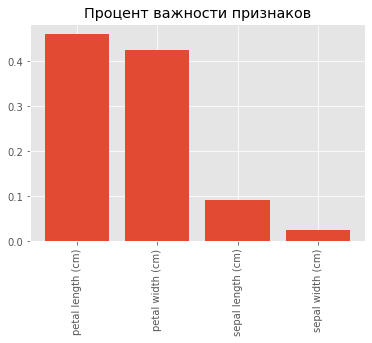

In [398]:
from scipy.sparse.construct import random
import numpy as np
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(random_state=0, n_jobs=-1) # создать объект-классификатор случайного леса
model = randomforest.fit(X, y) # натренировать модель
importances = model.feature_importances_ # вычислить важности признаков
indices = np.argsort(importances)[::-1] # отсортировать важности признаков в нисходящем порядке

# Перераспределить имена признаков, чтобы они совпадали
# с отсортированными важностями признаков
f_names = [iris.feature_names[i] for i in indices]
plt.figure()
plt.title("Процент важности признаков") 
plt.bar(range(X.shape[1]), importances[indices]) # добавить столбики
plt.xticks(range(X.shape[1]), f_names, rotation=90) # добавить имена признаков как метки оси X

plt.show()

Мощь алгоритма случайного леса проявляет себя при создании предсказательных моделей для данных с большим количеством признаков и записей. Алгоритм способен автоматически определять, какие предикторы важны, и обнаруживать сложные связи между предикторами, которые соответствуют членам взаимодействия.

# Самоорганизующаяся карта Кохонена


> для реализация использована библиотека susi (https://felixriese.github.io/susi/)





> ТРЕНИРОВОЧНАЯ ВЫБОРКА



In [399]:
y_train = []
for i in range(len(Y_train)):
  for j in range(len(Y_train[0])):
    if round(Y_train[i][j]) == 1:
      y_train.append(j)

**U-матрица (единая матрица расстояний)** - это представление самоорганизующейся карты (SOM), где евклидово расстояние между векторами соседних нейронов изображено на изображении в оттенках серого. Это изображение используется для визуализации данных в пространстве высокой размерности с помощью 2D-изображения.

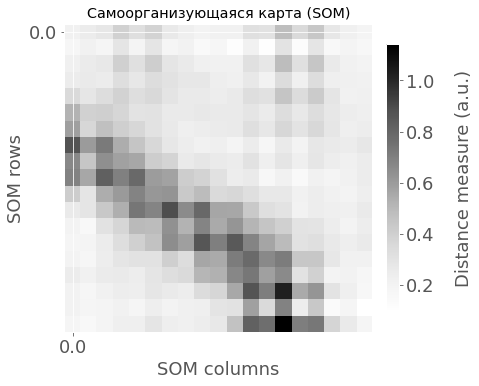

In [400]:
!pip install susi
import susi
from susi.SOMPlots import plot_nbh_dist_weight_matrix, plot_umatrix
som = susi.SOMClassifier() # создаём SOM-классификатор
som.fit(X_train, y_train) # тренируем модель на тренирующей выборке

u_matrix = som.get_u_matrix() # выводим саму самоорганизующуюся карту Кохонена в серых тонах
plot_umatrix(u_matrix, 9.3, 9.3)
plt.title("Самоорганизующаяся карта (SOM)")
plt.show()

> *Более тёмный цвет соответствует меньшему расстоянию между точками.*

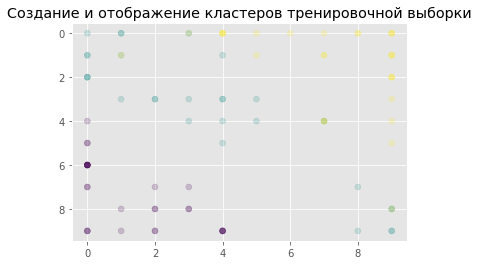

In [401]:
clusters = som.get_clusters(X_train) # разделяем на кластеры
plt.scatter(x=[c[1] for c in clusters], y=[c[0] for c in clusters], c=y_train, alpha=0.2) # выводим кластеры на график
plt.title("Создание и отображение кластеров тренировочной выборки")
plt.gca().invert_yaxis()
plt.show()

Матрица расстояний — это квадратная матрица типа «объект-объект» (порядка n), содержащая в качестве элементов расстояния между объектами в метрическом пространстве.

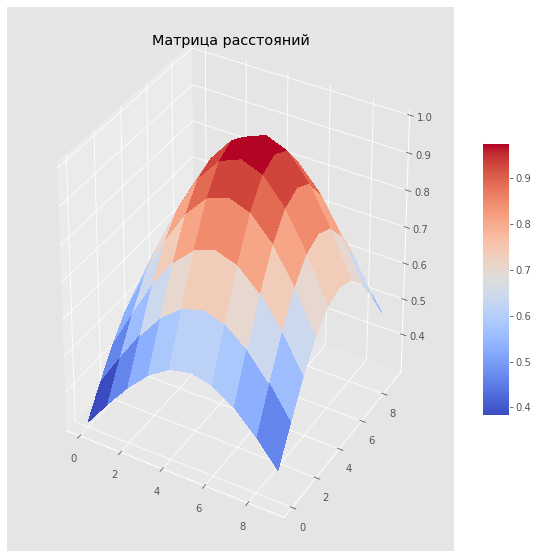

In [402]:
plot_nbh_dist_weight_matrix(som) # рассчитываем матрицу расстояний
plt.title("Матрица расстояний")
plt.show()



> ТЕСТИРУЮЩАЯ ВЫБОРКА



In [403]:
y_test = []
for i in range(len(Y_test)):
  for j in range(len(Y_test[0])):
    if round(Y_test[i][j]) == 1:
      y_test.append(j)

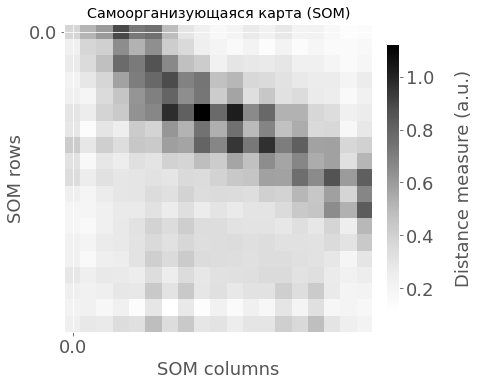

In [404]:
!pip install susi
import susi
from susi.SOMPlots import plot_nbh_dist_weight_matrix, plot_umatrix
som1 = susi.SOMClassifier()
som1.fit(X_test, y_test)

u_matrix1 = som1.get_u_matrix()
plot_umatrix(u_matrix1, 9.3, 9.3)
plt.title("Самоорганизующаяся карта (SOM)")
plt.show()

> *Более тёмный цвет соответствует меньшему расстоянию между точками.*

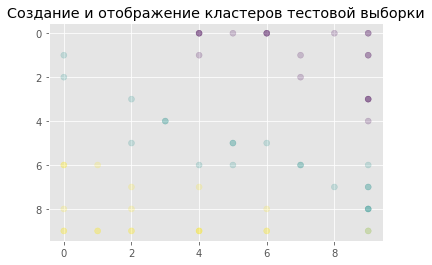

In [405]:
clusters1 = som1.get_clusters(X_test)
plt.scatter(x=[c[1] for c in clusters1], y=[c[0] for c in clusters1], c=y_test, alpha=0.2)
plt.title("Создание и отображение кластеров тестовой выборки")
plt.gca().invert_yaxis()
plt.show()

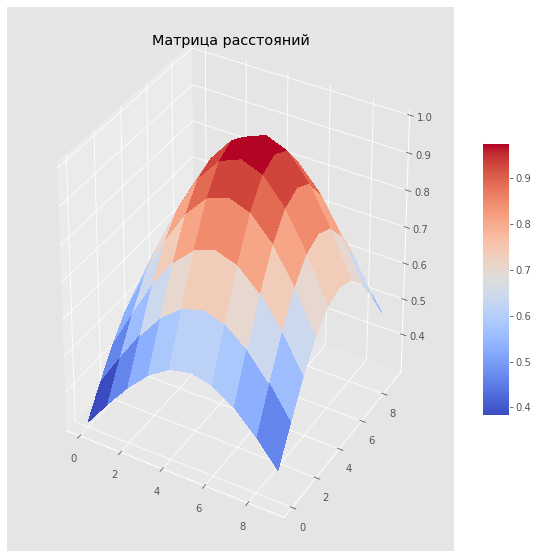

In [406]:
plot_nbh_dist_weight_matrix(som1)
plt.title("Матрица расстояний")
plt.show()



> ПРЕДСКАЗАНИЯ И ОЦЕНКА ТОЧНОСТИ МОДЕЛЕЙ ЧЕРЕЗ КОЭФФИЦИЕНТ ДЕТЕРМИНАЦИИ



In [407]:
# Сделать предсказания и рассчитать точность модели через коэффициент детерминации
y_pred_test = som1.predict(X_test)
y_pred_train = som.predict(X_train)

In [408]:
from sklearn.metrics import r2_score

print("Точность тестовой выборки:", r2_score(y_test, y_pred_test)) # точность модели
print("Точность тестирующей выборки:", r2_score(y_train, y_pred_train)) # точность модели

Точность тестовой выборки: 0.7691321077383497
Точность тестирующей выборки: 0.7704499908908726


No handles with labels found to put in legend.
No handles with labels found to put in legend.


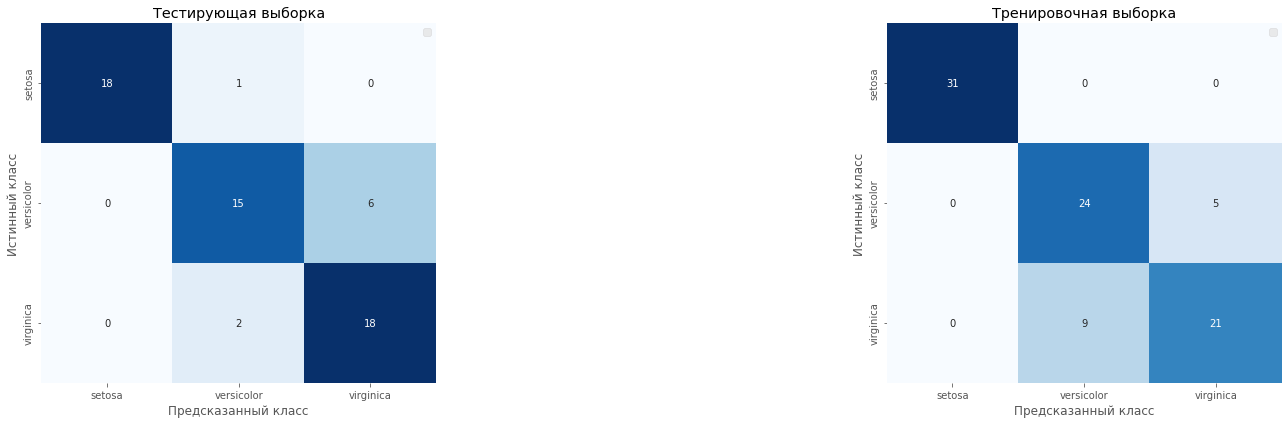

In [409]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

# Создать матрицу ошибок
matrix_test = confusion_matrix(y_test, y_pred_test)
matrix_train = confusion_matrix(y_train, y_pred_train)

# Создать фрейм данных pandas
dataframe_test = pd.DataFrame(matrix_test, index=names, columns=names)
dataframe_train = pd.DataFrame(matrix_train, index=names, columns=names)

# Создать тепловую карту
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.heatmap(dataframe_test, annot=True, cbar=None, cmap="Blues")
plt.title("Тестирующая выборка")
plt.tight_layout()
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.legend();

plt.subplot(1, 3, 3)
sns.heatmap(dataframe_train, annot=True, cbar=None, cmap="Blues")
plt.title("Тренировочная выборка")
plt.tight_layout()
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.legend();
plt.show()

# Вероятностная сеть

> для реализации использована библиотека neupy

No handles with labels found to put in legend.



Main information

[ALGORITHM] PNN

[OPTION] batch_size = 150
[OPTION] std = 10
[OPTION] verbose = True



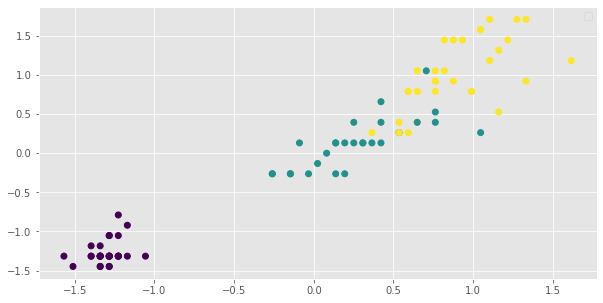

In [410]:
!pip install neupy
from neupy.algorithms import PNN

pnn = PNN(std=10, batch_size=150, verbose=True) # создаём модель вероятностной сети
pnn.train(X_train, y_train) # тренируем модель
prY_Train = pnn.predict(X_train) # делаем предсказания на основе тренировочной выборки
plt.figure(figsize=(10,5))
plt.scatter(X_train[:,2], X_train[:,3], marker='o', linewidths=1, c=prY_Train)
plt.legend();

**Отображаемые признаки:** 
*   (фиол.) – setosa
*   (син.) – versicolor
*   (жёлт.) – virginica

No handles with labels found to put in legend.


[0 1 2 0 2 2 2 0 0 2 1 0 2 2 1 0 1 1 0 0 1 1 2 0 2 1 0 0 1 1 1 2 1 2 2 0 1
 0 1 2 2 0 1 2 1 2 0 0 0 1 0 0 2 2 2 2 2 2 2 1]


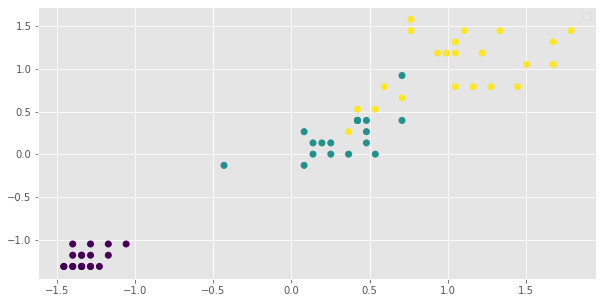

In [411]:
prY_Test = pnn.predict(X_test)
print(prY_Test)
plt.figure(figsize=(10,5))
plt.scatter(X_test[:,2], X_test[:,3], marker='o', linewidths=1, c=prY_Test)
plt.legend();

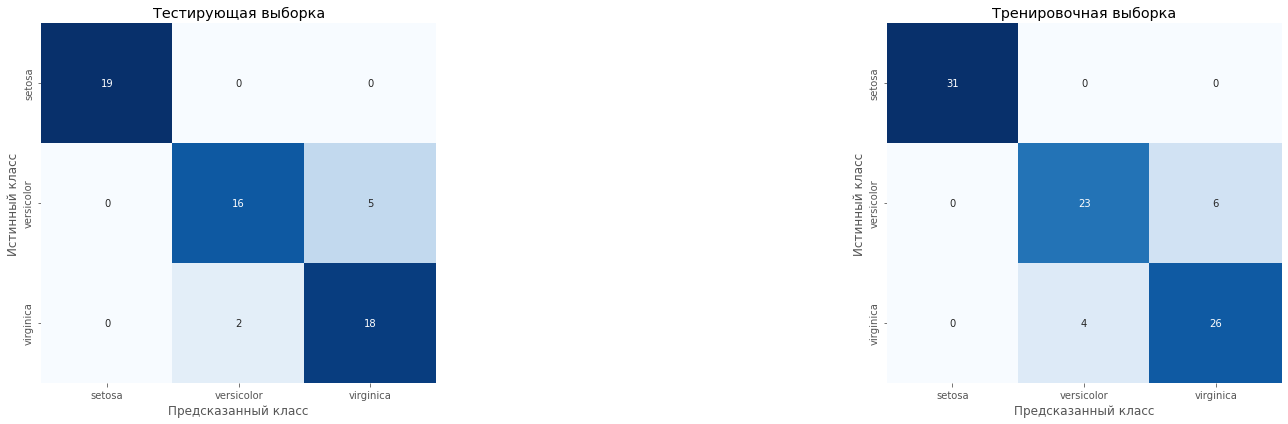

In [412]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
# Создать матрицу ошибок
matrix = confusion_matrix(y_test, prY_Test)
matrix2 = confusion_matrix(y_train, prY_Train)

# Создать фрейм данных pandas
dataframe1 = pd.DataFrame(matrix, index=names, columns=names)
dataframe2 = pd.DataFrame(matrix2, index=names, columns=names)

# Создать тепловую карту
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.heatmap(dataframe1, annot=True, cbar=None, cmap="Blues")
plt.title("Тестирующая выборка")
plt.tight_layout()
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")

plt.subplot(1, 3, 3)
sns.heatmap(dataframe2, annot=True, cbar=None, cmap="Blues")
plt.title("Тренировочная выборка")
plt.tight_layout()
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.show()

In [413]:
from sklearn.metrics import silhouette_score, r2_score

print("Точность тестовой выборки:", r2_score(y_test, prY_Test)) # точность модели
print("Точность тренировочной выборки:", r2_score(y_train, prY_Train)) # точность модели

Точность тестовой выборки: 0.8204360837964941
Точность тренировочной выборки: 0.8360357077791948


# Сеть с прямым распространение сигнала и обратным распространением ошибки

> для реализации использована библиотека keras

In [414]:
import numpy as np
%tensorflow_version 1.x
!pip install h5py==2.10.0
!pip install q keras==2.2.5
from keras import models
from keras import layers
import matplotlib.pyplot as plt

network = models.Sequential() # инициализировать нейронную сеть

# Добавить полносвязный слой с активационной функцией ReLU
network.add(layers.Dense(units=150,
                        activation='relu',
                        input_shape=(n_features,)))
# Добавить полносвязный слой с сигмоидальной активационной функцией
network.add(layers.Dense(units=150, activation='sigmoid'))
# Добавить полносвязный слой с активационной функцией softmax
network.add(layers.Dense(units=3, activation='softmax'))

# Скомпилировать нейронную сеть
network.compile(
   loss='categorical_crossentropy', # Перекрёстная энтропия
   optimizer='rmsprop', # Распространение среднеквадратической ошибки
   metrics=['accuracy'] # Точностный показатель результативности
)

network.summary() # вывести отчёт по слоям

TensorFlow is already loaded. Please restart the runtime to change versions.
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 150)               750       
_________________________________________________________________
dense_35 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 453       
Total params: 23,853
Trainable params: 23,853
Non-trainable params: 0
_________________________________________________________________


Train on 90 samples, validate on 60 samples
Epoch 1/50
90/90 [==============================] - 1s 8ms/step - loss: 1.2753 - acc: 0.3444 - val_loss: 1.0807 - val_acc: 0.3167
Epoch 2/50
90/90 [==============================] - 0s 74us/step - loss: 1.0850 - acc: 0.3444 - val_loss: 0.9690 - val_acc: 0.3167
Epoch 3/50
90/90 [==============================] - 0s 57us/step - loss: 0.9786 - acc: 0.3556 - val_loss: 0.8935 - val_acc: 0.4500
Epoch 4/50
90/90 [==============================] - 0s 123us/step - loss: 0.9042 - acc: 0.4444 - val_loss: 0.8342 - val_acc: 0.8500
Epoch 5/50
90/90 [==============================] - 0s 85us/step - loss: 0.8463 - acc: 0.8111 - val_loss: 0.7863 - val_acc: 0.9167
Epoch 6/50
90/90 [==============================] - 0s 102us/step - loss: 0.7982 - acc: 0.8556 - val_loss: 0.7448 - val_acc: 0.9000
Epoch 7/50
90/90 [==============================] - 0s 121us/step - loss: 0.7564 - acc: 0.8667 - val_loss: 0.7083 - val_acc: 0.9000
Epoch 8/50
90/90 [===================

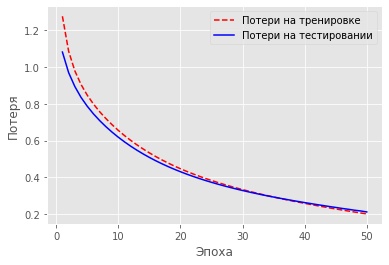

No handles with labels found to put in legend.


Точность модели: 0.8524235340997185


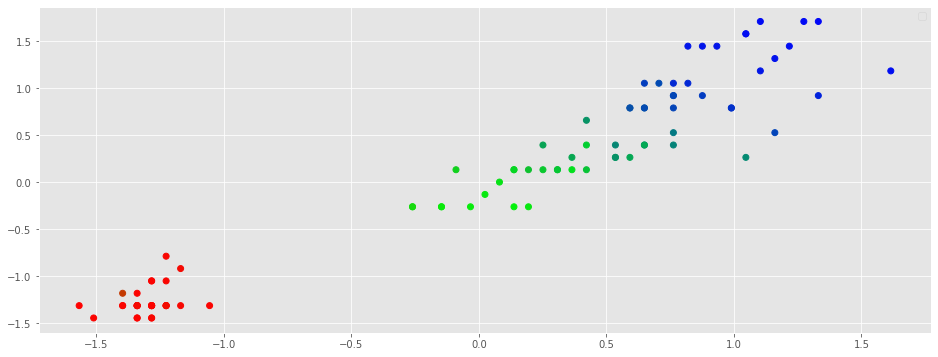

In [415]:
history = network.fit(X_train, # признаки
                      Y_train, # вектор целей
                      epochs=50, # количество эпох
                      verbose=1, # печатать описание после каждой эпохи
                      batch_size=150, # количество наблюдений на пакет
                      validation_data=(X_test, Y_test)) # тестовые данные
prY_Train = network.predict(X_train)

# Получить истории потерь на тренировочных и тестовых данных
training_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1) # создать счётчик количества эпох

# Визуализация истории потери
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Потери на тренировке', 
            'Потери на тестировании'])
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

from sklearn.metrics import r2_score
print("Точность модели:", r2_score(Y_train, prY_Train)) # точность модели через коэффициент детерминации

plt.figure(figsize=(16,6))
plt.scatter(X_train[:,2], X_train[:,3], marker='o', linewidths=1, c=prY_Train)
plt.legend();
plt.show()

Train on 60 samples, validate on 90 samples
Epoch 1/50
60/60 [==============================] - 0s 141us/step - loss: 0.2120 - acc: 0.9500 - val_loss: 0.2012 - val_acc: 0.9556
Epoch 2/50
60/60 [==============================] - 0s 195us/step - loss: 0.1963 - acc: 0.9667 - val_loss: 0.1947 - val_acc: 0.9556
Epoch 3/50
60/60 [==============================] - 0s 152us/step - loss: 0.1866 - acc: 0.9667 - val_loss: 0.1938 - val_acc: 0.9556
Epoch 4/50
60/60 [==============================] - 0s 160us/step - loss: 0.1787 - acc: 0.9667 - val_loss: 0.1911 - val_acc: 0.9556
Epoch 5/50
60/60 [==============================] - 0s 119us/step - loss: 0.1716 - acc: 0.9667 - val_loss: 0.1889 - val_acc: 0.9556
Epoch 6/50
60/60 [==============================] - 0s 116us/step - loss: 0.1652 - acc: 0.9667 - val_loss: 0.1866 - val_acc: 0.9556
Epoch 7/50
60/60 [==============================] - 0s 122us/step - loss: 0.1593 - acc: 0.9667 - val_loss: 0.1844 - val_acc: 0.9556
Epoch 8/50
60/60 [==============

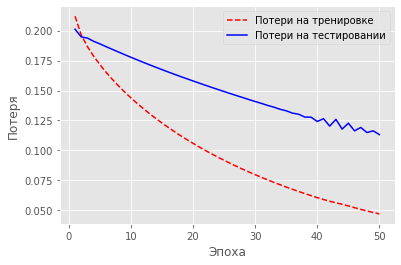

Точность модели: 0.9765783748843678


No handles with labels found to put in legend.


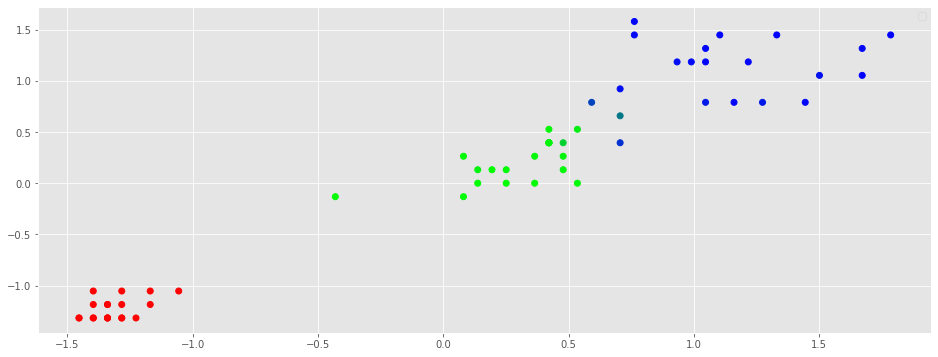

In [416]:
history = network.fit(X_test, 
                      Y_test, 
                      epochs=50, 
                      verbose=1, 
                      batch_size=150, 
                      validation_data=(X_train, Y_train))
prY_Test = network.predict(X_test)

training_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Потери на тренировке', 
            'Потери на тестировании'])
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.show()

from sklearn.metrics import r2_score
print("Точность модели:", r2_score(Y_test, prY_Test)) # точность модели

plt.figure(figsize=(16,6))
plt.scatter(X_test[:,2], X_test[:,3], marker='o', linewidths=1, c=prY_Test)
plt.legend();
plt.show()

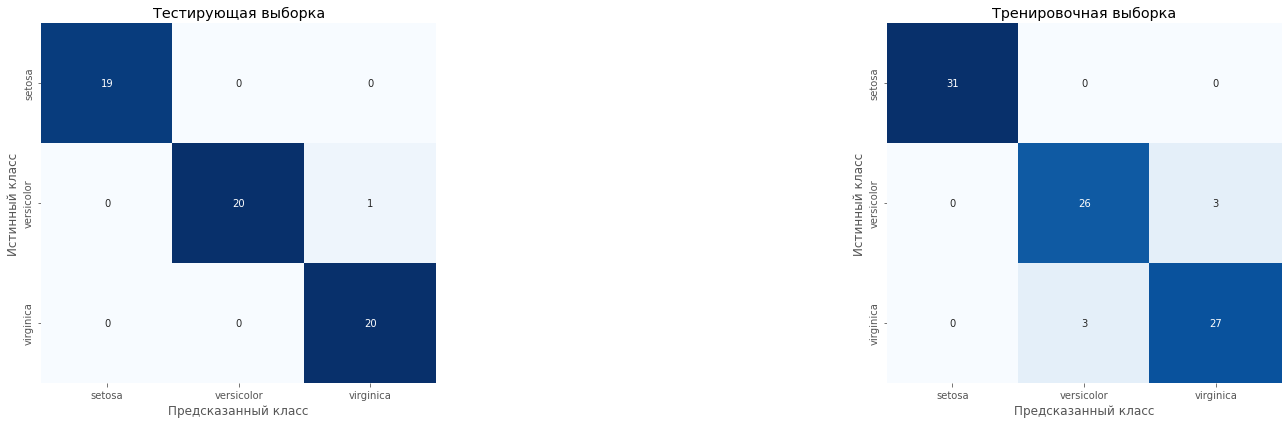


ヽ(°□° )ノ


In [417]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import numpy as np

# Создание одномерного массива из двумерного
def vector(Array):
  vec = []
  for i in range(len(Array)):
    vec.append(np.argmax(Array[i]))
  return vec

Y_Train = vector(Y_train)
pred_Y_Train = vector(prY_Train)
Y_Test = vector(Y_test)
pred_Y_Test = vector(prY_Test)

# Создать матрицу ошибок
matrix_test = confusion_matrix(Y_Test, pred_Y_Test)
matrix_train = confusion_matrix(Y_Train, pred_Y_Train)

# Создать фрейм данных pandas
dataframe_test = pd.DataFrame(matrix_test, index=names, columns=names)
dataframe_train = pd.DataFrame(matrix_train, index=names, columns=names)

# Создать тепловую карту
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.heatmap(dataframe_test, annot=True, cbar=None, cmap="Blues")
plt.title("Тестирующая выборка")
plt.tight_layout()
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")

plt.subplot(1, 3, 3)
sns.heatmap(dataframe_train, annot=True, cbar=None, cmap="Blues")
plt.title("Тренировочная выборка")
plt.tight_layout()
plt.ylabel("Истинный класс")
plt.xlabel("Предсказанный класс")
plt.show()
print("")
print("ヽ(°□° )ノ")